## Importing Libraries:

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier,AdaBoostClassifier,RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,f1_score
from sklearn.metrics import confusion_matrix,classification_report
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [57]:
df = pd.read_csv('OnlineNewsPopularity.csv')
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,kw_min_min,kw_max_min,kw_avg_min,kw_min_max,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg,self_reference_min_shares,self_reference_max_shares,self_reference_avg_sharess,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_saturday,weekday_is_sunday,is_weekend,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,0.0,4.680365,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,496.0,496.0,496.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500331,0.378279,0.040005,0.041263,0.040123,0.521617,0.092562,0.045662,0.013699,0.769231,0.230769,0.378636,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,0.0,4.913725,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.799756,0.050047,0.050096,0.050101,0.050001,0.341246,0.148948,0.043137,0.015686,0.733333,0.266667,0.286915,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,0.0,4.393365,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,918.0,918.0,918.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.217792,0.033334,0.033351,0.033334,0.682188,0.702222,0.323333,0.056872,0.009479,0.857143,0.142857,0.495833,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,0.0,4.404896,7.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028573,0.419300,0.494651,0.028905,0.028572,0.429850,0.100705,0.041431,0.020716,0.666667,0.333333,0.385965,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,0.0,4.682836,7.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,545.0,16000.0,3151.157895,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028633,0.028794,0.028575,0.028572,0.885427,0.513502,0.281003,0.074627,0.012127,0.860215,0.139785,0.411127,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


## DataCleaning

In [58]:
new_cols=[]
for col in df.columns:
    new_cols.append(col.strip())
df.columns=new_cols

In [59]:
median=df['shares'].median()
median

1400.0

In [60]:
status=[]
for i in df['shares']:
    if(i>=1400):
        status.append('popular')
    else:
        status.append("unpopular")
df['status']=status
    

Categorizing the shares by considering the shares above 1400 to be popular and below 1400 as unpopular

In [61]:
df['status']=df['status'].replace({'popular':1,'unpopular':0})

In [62]:
df.drop(['url','shares','timedelta'],axis=1,inplace=True)

## Model Building 

In [63]:
def model(data,col):
    X=data.drop(col,axis=1)
    y=data[col]
    from sklearn.model_selection import train_test_split
    Xtrain,Xtest,ytrain,ytest=train_test_split(X,y,test_size=0.3,random_state=1)
    return Xtrain,Xtest,ytrain,ytest

def model_buliding(data,col,func):
    Xtrain,Xtest,ytrain,ytest=model(data,col)
    func.fit(Xtrain,ytrain)
    ypred=func.predict(Xtest)

    score=accuracy_score(ytest,ypred)
    f_score=f1_score(ypred,ytest)
    
    cm = confusion_matrix(ytest,ypred)
    conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
    plt.figure(figsize = (8,5))
    print(func)
    sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

    roc(Xtest,ytest,func)
    print(classification_report(ytest, ypred))
    return ypred,score,f_score



In [64]:
def roc(Xtest,ytest,func):
    from sklearn.metrics import roc_curve,roc_auc_score
    yprob = func.predict_proba(Xtest)
    fpr,tpr,threshold = roc_curve(ytest,yprob[:,1])
    roc_auc = roc_auc_score(ytest,yprob[:,1])

    print('ROC AUC =', roc_auc)
    plt.figure()
    lw = 2
    plt.plot(fpr,tpr,color='darkorange',lw=lw,label='ROC Curve (area = %0.2f)'%roc_auc)
    plt.plot([0,1],[0,1],color='navy',lw=lw,linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()
    

## Logistic Regression:

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
ROC AUC = 0.6481597886255617


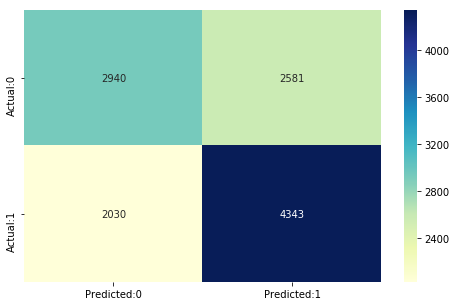

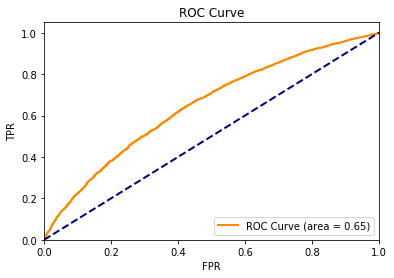

              precision    recall  f1-score   support

           0       0.59      0.53      0.56      5521
           1       0.63      0.68      0.65      6373

   micro avg       0.61      0.61      0.61     11894
   macro avg       0.61      0.61      0.61     11894
weighted avg       0.61      0.61      0.61     11894



In [65]:
ypred_log,score_log,f_score_log=model_buliding(df,'status',LogisticRegression())


From Logistic Regression we got an accuracy of 61.2% and f1 score of 65%.

## Decision Tree:

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
ROC AUC = 0.5697626053446759


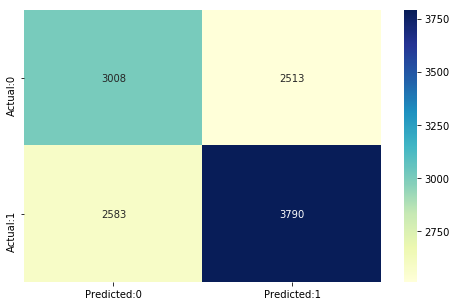

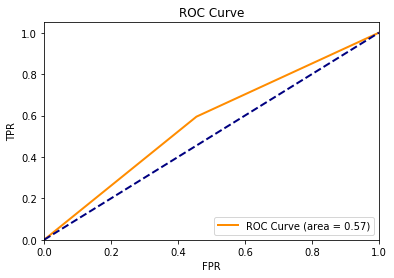

              precision    recall  f1-score   support

           0       0.54      0.54      0.54      5521
           1       0.60      0.59      0.60      6373

   micro avg       0.57      0.57      0.57     11894
   macro avg       0.57      0.57      0.57     11894
weighted avg       0.57      0.57      0.57     11894



In [66]:
ypred_dt,score_dt,f_score_dt=model_buliding(df,'status',DecisionTreeClassifier())

From Decision Tree we got an accuracy of 57% and f1 score of 59%.

## Bagging:

BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=None, oob_score=False, random_state=None,
         verbose=0, warm_start=False)
ROC AUC = 0.6743654095870003


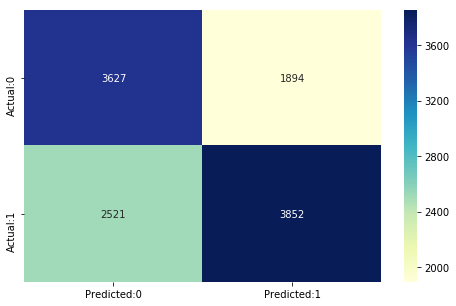

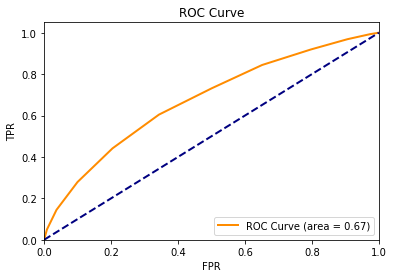

              precision    recall  f1-score   support

           0       0.59      0.66      0.62      5521
           1       0.67      0.60      0.64      6373

   micro avg       0.63      0.63      0.63     11894
   macro avg       0.63      0.63      0.63     11894
weighted avg       0.63      0.63      0.63     11894



In [67]:
ypred_bc,score_bc,f_score_bc=model_buliding(df,'status',BaggingClassifier())


From Bagging we got an accuracy of 62.8% and f1 score of 63.5%

## AdaBoost:

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)
ROC AUC = 0.7248309686311624


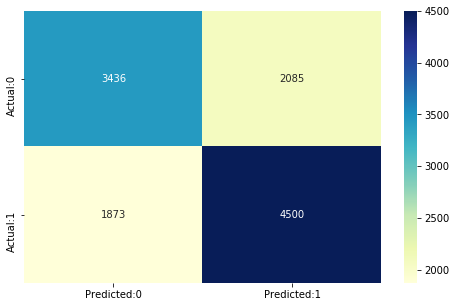

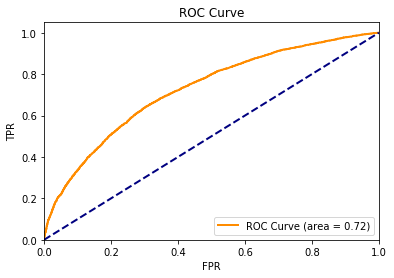

              precision    recall  f1-score   support

           0       0.65      0.62      0.63      5521
           1       0.68      0.71      0.69      6373

   micro avg       0.67      0.67      0.67     11894
   macro avg       0.67      0.66      0.66     11894
weighted avg       0.67      0.67      0.67     11894



In [68]:
ypred_adc,score_adc,f_score_adc=model_buliding(df,'status',AdaBoostClassifier())

From Adaboost we got an accuracy of 66.7% and f1 score of 69.4%

## Random Forest:

In [69]:
from sklearn.model_selection import train_test_split
X=df.drop(['status'],axis=1)
y=df['status']
Xtrain,Xtest,ytrain,ytest=train_test_split(X,y,test_size=0.3,random_state=1)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
ROC AUC = 0.6700368161927015


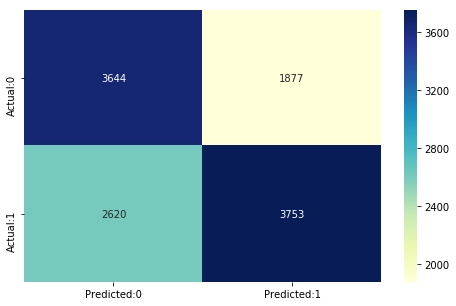

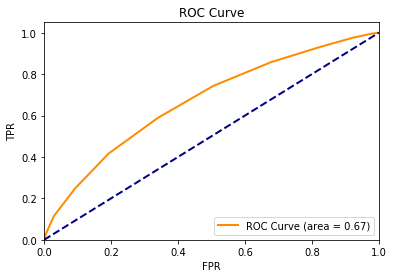

              precision    recall  f1-score   support

           0       0.58      0.66      0.62      5521
           1       0.67      0.59      0.63      6373

   micro avg       0.62      0.62      0.62     11894
   macro avg       0.62      0.62      0.62     11894
weighted avg       0.63      0.62      0.62     11894



In [70]:
ypred_rf,score_rf,f_score_rf=model_buliding(df,'status',RandomForestClassifier())

In [71]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
param_grid = {'max_features': [4,6,10,20,30]}

rf = RandomForestClassifier(n_estimators=100)
rf_grid = GridSearchCV(rf, param_grid, scoring='f1')
rf_grid.fit(Xtrain, ytrain)
ypred_rf=rf_grid.predict(Xtest)
score_rf=accuracy_score(ytest,ypred_rf)
f_score_rf=f1_score(ypred_rf,ytest)
print("f1_score: ",f_score_rf)
score_rf


f1_score:  0.7011485510002282


0.6696653775012611

In [72]:
rf_grid.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=6, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

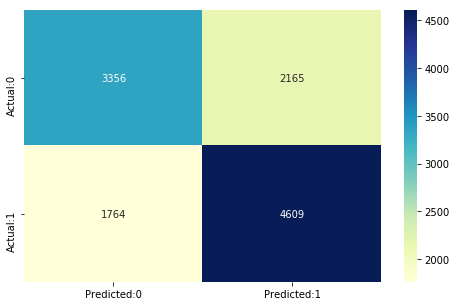

In [73]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(ytest,ypred_rf)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

ROC AUC = 0.971460992255766


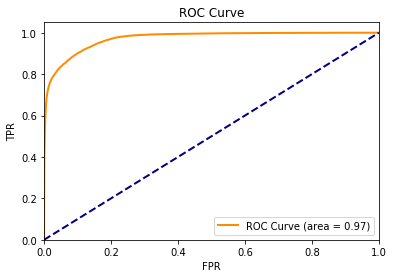

In [74]:
from sklearn.metrics import roc_curve,roc_auc_score
yprob = rf_grid.predict_proba(X)
fpr,tpr,threshold = roc_curve(y,yprob[:,1])
roc_auc = roc_auc_score(y,yprob[:,1])

print('ROC AUC =', roc_auc)
plt.figure()
lw = 2
plt.plot(fpr,tpr,color='darkorange',lw=lw,label='ROC Curve (area = %0.2f)'%roc_auc)
plt.plot([0,1],[0,1],color='navy',lw=lw,linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [75]:
from sklearn.metrics import classification_report
print('Random Forest:')
print(classification_report(ytest, ypred_rf))

Random Forest:
              precision    recall  f1-score   support

           0       0.66      0.61      0.63      5521
           1       0.68      0.72      0.70      6373

   micro avg       0.67      0.67      0.67     11894
   macro avg       0.67      0.67      0.67     11894
weighted avg       0.67      0.67      0.67     11894



From Random Forest we got an accuracy of 66.9% and 70.1%

In [76]:
results=pd.DataFrame({'accuracy':[score_log,score_dt,score_rf,score_bc,score_adc,],'f1_score':[f_score_log,f_score_dt,f_score_rf,f_score_bc,f_score_adc]},index=['Logistic','Decision','Random Fores','Bagging','adaboost'])

In [77]:
results

,accuracy,f1_score
Logistic,0.612326,0.653230
Decision,0.571549,0.597980
Random Fores,0.669665,0.701149
Bagging,0.628804,0.635696
adaboost,0.667227,0.694552


### Scaled Logistic Regression:

In [78]:
def scale(data,col):
    from sklearn.preprocessing import MinMaxScaler
    sc=MinMaxScaler()
    X=data.drop(col,axis=1)
    y=data[col]
    from sklearn.model_selection import train_test_split
    Xtrain,Xtest,ytrain,ytest=train_test_split(X,y,test_size=0.3,random_state=1)
    col=Xtrain.columns
    scaled_X=pd.DataFrame(sc.fit_transform(Xtrain),columns=col)
    scaled_Xtest=pd.DataFrame(sc.transform(Xtest),columns=col)
    return scaled_X,scaled_Xtest,ytrain,ytest


def scaled_model_buliding(data,col,func):
    Xtrain,Xtest,ytrain,ytest=scale(data,col)
    func.fit(Xtrain,ytrain)
    ypred=func.predict(Xtest)

    score=accuracy_score(ytest,ypred)
    f_score=f1_score(ypred,ytest)
    
    cm = confusion_matrix(ytest,ypred)
    conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
    plt.figure(figsize = (8,5))
    print(func)
    sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

    roc(Xtest,ytest,func)
    return ypred,score,f_score

## Logistic Regression scaled:

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
ROC AUC = 0.7019510373825366


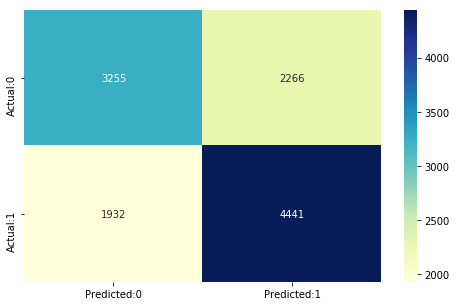

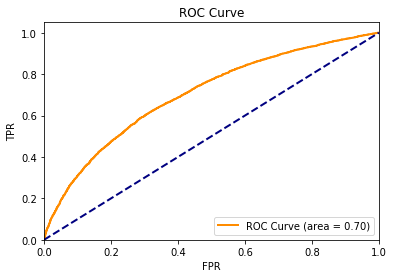

In [79]:
ypred_log_scale,score_log_scale,f_score_log_scale=scaled_model_buliding(df,'status',LogisticRegression())


## Decision tree Scaled:

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
ROC AUC = 0.575255490689828


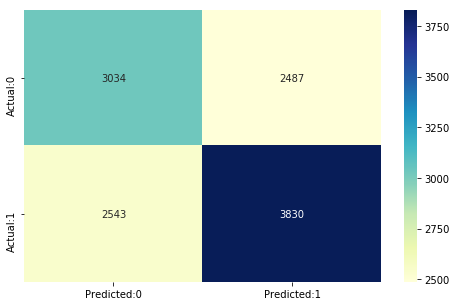

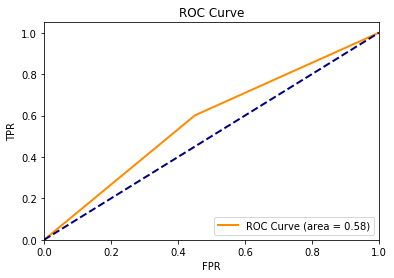

In [80]:
ypred_dt_scale,score_dt_scale,f_score_dt_scale=scaled_model_buliding(df,'status',DecisionTreeClassifier())


## Bagging Scaled:

BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=None, oob_score=False, random_state=None,
         verbose=0, warm_start=False)
ROC AUC = 0.6798698338310455


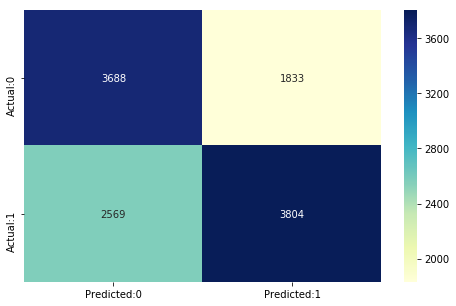

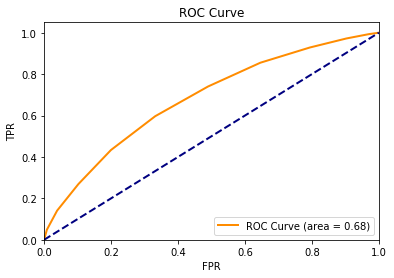

In [81]:
ypred_bc_scale,score_bc_scale,f_score_bc_scale=scaled_model_buliding(df,'status',BaggingClassifier())

## Ada boost scaled:

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)
ROC AUC = 0.7254265719184751


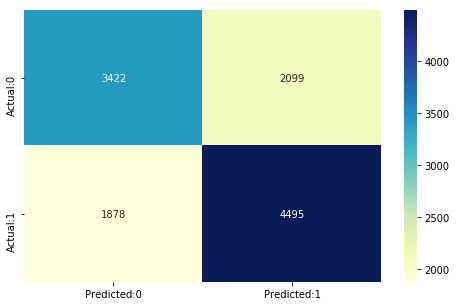

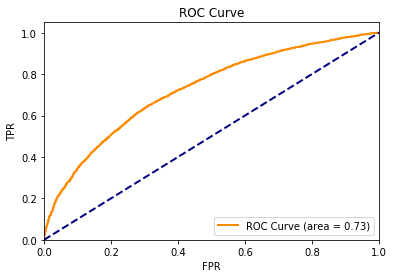

In [82]:
ypred_adc_scale,score_adc_scale,f_score_adc_scale=scaled_model_buliding(df,'status',AdaBoostClassifier())

In [83]:
results_scale=pd.DataFrame({'accuracy':[score_log_scale,score_dt_scale,score_bc_scale,score_adc_scale],'f1_score':[f_score_log_scale,f_score_dt_scale,f_score_bc_scale,f_score_adc_scale]},index=['Logistic','Decision','Bagging','adaboost'])

In [84]:
results_scale

,accuracy,f1_score
Logistic,0.647049,0.679052
Decision,0.577098,0.603625
Bagging,0.629897,0.633472
adaboost,0.665630,0.693298


## Choosing Significant features

In [85]:
from scipy.stats import f_oneway
significant_cols=[]
notsignificant_cols=[]
for col in df.columns:
    set1=df[df['status']==0][col]
    set2=df[df['status']==1][col]
    a=f_oneway(set1,set2)
    print(col,':','F-stat',a[0],'p-value  :',a[1])
    if(a[1] < 0.05):
        print(col,'is significant')
        print("")
        significant_cols.append(col)
    else :
        print(col,'is not significant')
        print("")
        notsignificant_cols.append(col)

n_tokens_title : F-stat 76.94010298344313 p-value  : 1.8309297095960876e-18
n_tokens_title is significant

n_tokens_content : F-stat 68.16923890945306 p-value  : 1.5463749493451268e-16
n_tokens_content is significant

n_unique_tokens : F-stat 0.3189768452194656 p-value  : 0.5722263689539537
n_unique_tokens is not significant

n_non_stop_words : F-stat 0.6711998575506622 p-value  : 0.41263851988370415
n_non_stop_words is not significant

n_non_stop_unique_tokens : F-stat 0.17345218190716935 p-value  : 0.677064047918635
n_non_stop_unique_tokens is not significant

num_hrefs : F-stat 325.38409776353325 p-value  : 1.898143911571513e-72
num_hrefs is significant

num_self_hrefs : F-stat 65.19451579409109 p-value  : 6.975645727036432e-16
num_self_hrefs is significant

num_imgs : F-stat 179.79220628101578 p-value  : 6.607505832343705e-41
num_imgs is significant

num_videos : F-stat 2.142019331561438 p-value  : 0.14332106712104487
num_videos is not significant

average_token_length : F-stat 32.

Getting the significant features which has p-value > 0.05 

In [86]:
data=df[significant_cols]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
ROC AUC = 0.6484405590249778


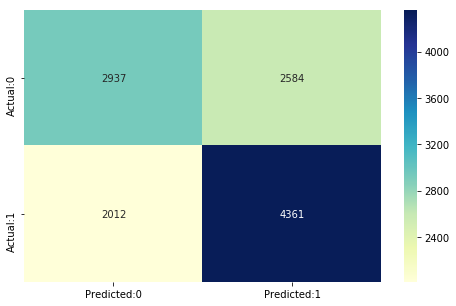

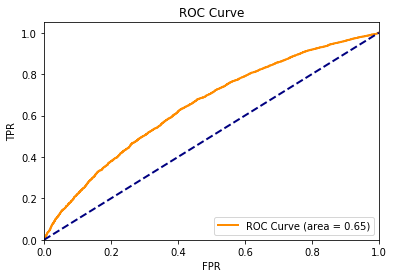

              precision    recall  f1-score   support

           0       0.59      0.53      0.56      5521
           1       0.63      0.68      0.65      6373

   micro avg       0.61      0.61      0.61     11894
   macro avg       0.61      0.61      0.61     11894
weighted avg       0.61      0.61      0.61     11894

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
ROC AUC = 0.5734989491217831


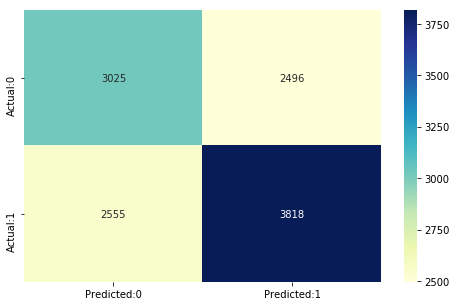

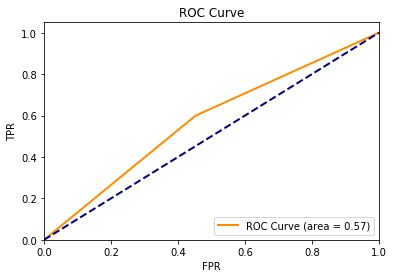

              precision    recall  f1-score   support

           0       0.54      0.55      0.54      5521
           1       0.60      0.60      0.60      6373

   micro avg       0.58      0.58      0.58     11894
   macro avg       0.57      0.57      0.57     11894
weighted avg       0.58      0.58      0.58     11894

BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=None, oob_score=False, random_state=None,
         verbose=0, warm_start=False)
ROC AUC = 0.6807508117089583


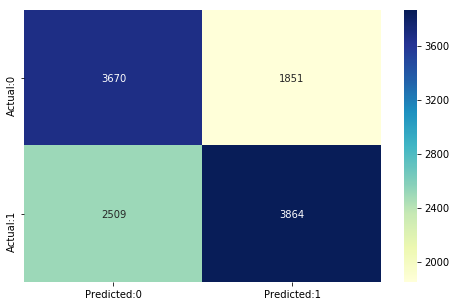

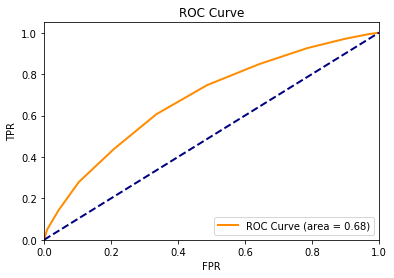

              precision    recall  f1-score   support

           0       0.59      0.66      0.63      5521
           1       0.68      0.61      0.64      6373

   micro avg       0.63      0.63      0.63     11894
   macro avg       0.64      0.64      0.63     11894
weighted avg       0.64      0.63      0.63     11894

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)
ROC AUC = 0.7243798999998096


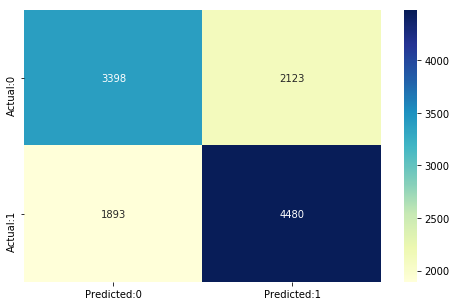

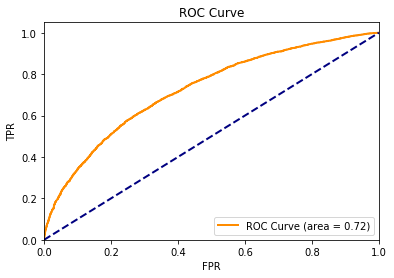

              precision    recall  f1-score   support

           0       0.64      0.62      0.63      5521
           1       0.68      0.70      0.69      6373

   micro avg       0.66      0.66      0.66     11894
   macro avg       0.66      0.66      0.66     11894
weighted avg       0.66      0.66      0.66     11894



In [87]:

ypred_log_sig,score_log_sig,f_score_log_sig=model_buliding(data,'status',LogisticRegression())
ypred_dt_sig,score_dt_sig,f_score_dt_sig=model_buliding(data,'status',DecisionTreeClassifier())
ypred_bc_sig,score_bc_sig,f_score_bc_sig=model_buliding(data,'status',BaggingClassifier())
ypred_adc_sig,score_adc_sig,f_score_adc_sig=model_buliding(data,'status',AdaBoostClassifier())

results_1=pd.DataFrame({'accuracy':[score_log_sig,score_dt_sig,score_bc_sig,score_adc_sig],'f1_score':[f_score_log_sig,f_score_dt_sig,f_score_bc_sig,f_score_adc_sig]},index=['Logistic','Decision','Bagging','adaboost'])

In [88]:
results_1

,accuracy,f1_score
Logistic,0.613587,0.654903
Decision,0.575332,0.601876
Bagging,0.633429,0.639312
adaboost,0.662351,0.690506


## stacking

In [89]:
stac=pd.DataFrame({'log':ypred_log,'Random':ypred_rf,'Boost':ypred_adc,'y':ytest})

In [90]:
x=stac.drop('y',axis=1)
y=stac['y']
Xtrain,Xtest,ytrain,ytest=train_test_split(x,y,test_size=0.3,random_state=1)
lr = LogisticRegression()
lr.fit(Xtrain,ytrain)
ypred_stac=lr.predict(Xtest)
score_stac=accuracy_score(ytest,ypred_stac)
f1_score_stac=f1_score(ytest,ypred_stac)
print("f1 score: ",f1_score_stac)
print("accuracy: ",score_stac)

f1 score:  0.7005050505050505
accuracy:  0.6676940319417204


In [ ]:
Tried of doing stacking.

In [91]:
adc=AdaBoostClassifier()
adc.fit(Xtrain, ytrain)
ypred_adc_stac=adc.predict(Xtest)
score_adc_stac=accuracy_score(ytest,ypred_adc_stac)
f_score_adc_stac=f1_score(ypred_adc_stac,ytest)
print("f1_score: ",f_score_adc_stac)
score_adc_stac

f1_score:  0.7005050505050505


0.6676940319417204

In [93]:
def model(data,col):
    X=data.drop(col,axis=1)
    y=data[col]
    from sklearn.model_selection import train_test_split
    Xtrain,Xtest,ytrain,ytest=train_test_split(X,y,test_size=0.3,random_state=1)
    return Xtrain,Xtest,ytrain,ytest

def model_buliding2(data,col,func):
    Xtrain,Xtest,ytrain,ytest=model(data,col)
    func.fit(Xtrain,ytrain)
    ypred=func.predict(Xtest)

    score=accuracy_score(ytest,ypred)
    f_score=f1_score(ypred,ytest)
    
    cm = confusion_matrix(ytest,ypred)
    conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
    plt.figure(figsize = (8,5))
    print(func)
    #sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

    roc(Xtest,ytest,func)
    #print(classification_report(ytest, ypred))
    return ypred,score,f_score



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
ROC AUC = 0.6484405590249778


<Figure size 576x360 with 0 Axes>

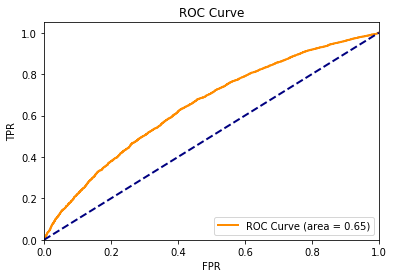

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
ROC AUC = 0.6733200166103303


<Figure size 576x360 with 0 Axes>

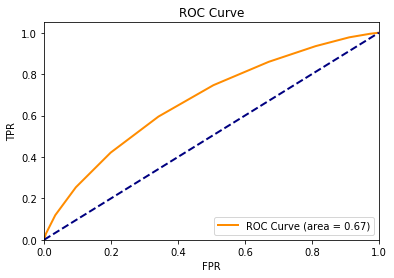

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
ROC AUC = 0.5753174767452108


<Figure size 576x360 with 0 Axes>

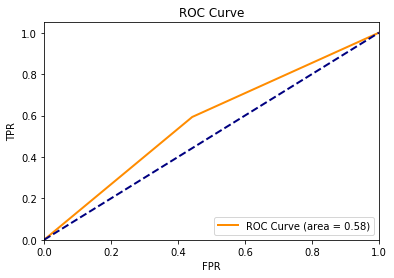

In [94]:
model1=[LogisticRegression(),RandomForestClassifier(),DecisionTreeClassifier()]
for i in model1:
    model_buliding2(data,'status',i)